In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.models import Word2Vec
import numpy as np
import umap # pip install umap-learn
import hdbscan
import matplotlib.pyplot as plt

c:\ProgramFiles\Anaconda3\envs\nlp10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
# Load the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

df_train = pd.DataFrame({'text': newsgroups_train.data, 'label': newsgroups_train.target})
df_test = pd.DataFrame({'text': newsgroups_test.data, 'label': newsgroups_test.target})

df_train['label'] = df_train['label'].map(lambda x: newsgroups_train.target_names[x])
df_test['label'] = df_test['label'].map(lambda x: newsgroups_test.target_names[x])

df_train = df_train[df_train['label'].isin(['rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.religion.misc'])]
df_test = df_test[df_test['label'].isin(['rec.sport.baseball', 'comp.graphics', 'sci.space', 'talk.religion.misc'])]

In [52]:
len(df_train), len(df_test)

(2151, 1431)

In [ ]:
# df_train = df_train.sample(300)
# df_test = df_test.sample(100)
len(df_train), len(df_test)

(300, 100)

In [53]:
import re

def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    tokens = text.split()  # Simple split by spaces
    tokens = [token for token in tokens if token not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return tokens

df_train['tokens'] = df_train['text'].apply(tokenize)
df_test['tokens'] = df_test['text'].apply(tokenize)

In [54]:
w2v_model = Word2Vec(sentences=df_train['tokens'], vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save("news_word2vec.model")

In [55]:
import numpy as np

def get_text_embedding(tokens, model):
    embeddings = []
    for token in tokens:
        if token in model.wv:
            embeddings.append(model.wv[token])
    if len(embeddings) == 0:
        return np.zeros(model.vector_size)
    return np.mean(embeddings, axis=0)

df_train['embedding'] = df_train['tokens'].apply(lambda tokens: get_text_embedding(tokens, w2v_model))
df_test['embedding'] = df_test['tokens'].apply(lambda tokens: get_text_embedding(tokens, w2v_model))

In [56]:
import umap

embeddings = np.vstack(df_train['embedding'].values)

umap_model = umap.UMAP(n_components=2)  # Set n_components=2 for 2D projection, or 3 for 3D
umap_embeddings = umap_model.fit_transform(embeddings)
umap_embeddings_test = umap_model.transform(np.vstack(df_test['embedding'].values))

df_train['umap_1'] = umap_embeddings[:, 0]
df_train['umap_2'] = umap_embeddings[:, 1]

df_test['umap_1'] = umap_embeddings_test[:, 0]
df_test['umap_2'] = umap_embeddings_test[:, 1]

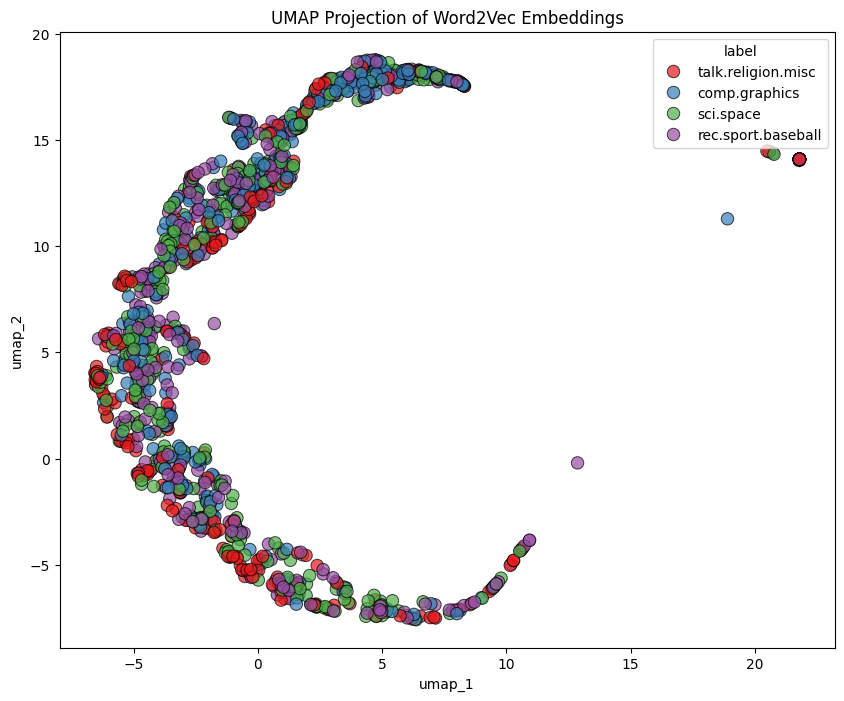

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='umap_1', y='umap_2', hue='label', data=df_test, palette='Set1', s=80, edgecolor='k', alpha=0.7)

plt.title('UMAP Projection of Word2Vec Embeddings')
plt.show()


In [58]:
from sklearn.metrics import silhouette_score

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
df_test['cluster_umap'] = hdbscan_model.fit_predict(umap_embeddings_test) # UMAP embeddings

labels = hdbscan_model.labels_
num_clusters = len(set(labels) - {-1})
print(f"Number of clusters (excluding noise): {num_clusters}")

if (num_clusters > 0):
  labels = hdbscan_model.labels_
  embeddings = umap_embeddings_test

  # Only consider points that are not labeled as noise (-1)
  non_noise_mask = labels != -1
  filtered_embeddings = embeddings[non_noise_mask]
  filtered_labels = labels[non_noise_mask]

  # Calculate the silhouette score
  sil_score = silhouette_score(filtered_embeddings, filtered_labels, metric='euclidean')

  print(f"Silhouette Score: {sil_score}")

Number of clusters (excluding noise): 71
Silhouette Score: 0.6235799193382263


In [59]:
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
df_test['cluster_word2vec'] = hdbscan_model.fit_predict(np.vstack(df_test['embedding'].values)) # Direct Word2Vec embeddings

labels = hdbscan_model.labels_
num_clusters = len(set(labels) - {-1})
print(f"Number of clusters (excluding noise): {num_clusters}")

if (num_clusters > 0):
  labels = hdbscan_model.labels_
  embeddings = np.vstack(df_test['embedding'].values)

  # Only consider points that are not labeled as noise (-1)
  non_noise_mask = labels != -1
  filtered_embeddings = embeddings[non_noise_mask]
  filtered_labels = labels[non_noise_mask]

  # Calculate the silhouette score
  sil_score = silhouette_score(filtered_embeddings, filtered_labels, metric='euclidean')

  print(f"Silhouette Score: {sil_score}")

Number of clusters (excluding noise): 9
Silhouette Score: 0.26531767821501573


In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
label_encoder = LabelEncoder()
df_test['label_numeric'] = label_encoder.fit_transform(df_test['label'])
f1 = f1_score(df_test['label_numeric'], df_test['cluster_umap'], average='macro')
print(f"F1 Score: {f1}")  # True labels are just a conversion to numbers.. so probably the F1 score is invalid

F1 Score: 0.0009689526294478852
